In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import numpy as np
from utils import * 
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
img_size = 112

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to 224x224
    transforms.RandomRotation(degrees=15),  # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Randomly changes brightness, contrast, and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor()
])


root_dir = 'cls_training_data_by_vid'
dataset = datasets.ImageFolder(root=root_dir)
# check class balance
class_names = dataset.classes

class_count = {}
for i in range(len(class_names)):
    class_count[class_names[i]] = 0
for img, label in dataset:
    class_count[class_names[label]] += 1
print(class_count)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



{'0': 1471, '1': 497}


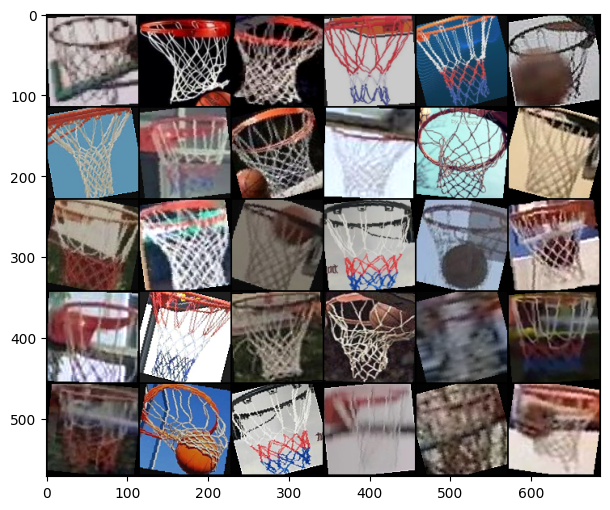

In [3]:
def imshow(img, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def visualize_transform(train_transforms = train_transforms, root_dir = root_dir, subset_size = 30 ):
    subset_dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)

    # Select 30 random images from the subset
    subset_size = 30  # Number of images to display
    subset_indices = torch.randperm(len(subset_dataset))[:subset_size]

    # Using Subset to create a smaller dataset
    visualize_subset = torch.utils.data.Subset(subset_dataset, subset_indices)

    # DataLoader for the subset
    visualize_loader = DataLoader(visualize_subset, batch_size=subset_size, shuffle=False)

    # Retrieve the images from the loader
    images_transformed, _ = next(iter(visualize_loader))

    # Convert the images to a grid
    images_grid = torchvision.utils.make_grid(images_transformed, nrow=6, padding=2)
    imshow(images_grid)
visualize_transform()

In [27]:
num_classes = 2

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.5)
print(device)

cuda:1


In [28]:
def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10, chkpt_interval=5, checkpoint_dir='./cls_chkpoint', early_stopping_patience=3, resume_checkpoint_path=None, scheduler=None):
    now = datetime.datetime.now()
    checkpoint_dir = os.path.join(checkpoint_dir, now.strftime('checkpoint_%Y-%m-%d-%H-%M') + f'_lr_{optimizer.param_groups[0]["lr"]}_batch_{train_loader.batch_size}')
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    start_epoch = 0
    best_accuracy = 0.0
    best_loss = float('inf')
    early_stopping_counter = 0

    # Resume from a checkpoint if provided
    if resume_checkpoint_path and os.path.isfile(resume_checkpoint_path):
        checkpoint = torch.load(resume_checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        best_accuracy = checkpoint.get('best_accuracy', best_accuracy)
        best_loss = checkpoint.get('best_loss', best_loss)
        losses = np.append(checkpoint['train_loss'], np.empty(num_epochs - len(checkpoint['train_loss'])))
        test_losses = np.append(checkpoint['val_loss'], np.empty(num_epochs - len(checkpoint['val_loss'])))
        train_accuracies = np.append(checkpoint['train_acc'], np.empty(num_epochs - len(checkpoint['train_acc'])))
        test_accuracies = np.append(checkpoint['val_acc'], np.empty(num_epochs - len(checkpoint['val_acc'])))
    else:
        # Initialize arrays to track the losses and accuracies
        losses = np.empty(num_epochs)
        test_losses = np.empty(num_epochs)
        train_accuracies = np.empty(num_epochs)
        test_accuracies = np.empty(num_epochs)
        
    

    
    for epoch in range(start_epoch, num_epochs):
        temp = time.time()
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == targets).sum().item()
        
        avg_loss = total_loss / len(train_loader.dataset)
        losses[epoch] = avg_loss
        train_accuracies[epoch] = correct_predictions / len(train_loader.dataset)
        
        model.eval()
        correct_test_predictions = 0
        total_test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                test_loss = criterion(outputs, targets)
                total_test_loss += test_loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_test_predictions += (predicted == targets).sum().item()
        
        test_accuracies[epoch] = correct_test_predictions / len(test_loader.dataset)
        test_losses[epoch] = total_test_loss / len(test_loader.dataset)
        
        # Save checkpoint after every epoch
        if (epoch + 1) % chkpt_interval == 0:
            checkpoint = {
               'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': losses[:epoch+1],
                'train_acc': train_accuracies[:epoch+1],
                'val_loss': test_losses[:epoch+1],
                'val_acc': test_accuracies[:epoch+1]
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save(checkpoint, checkpoint_path)
        
        # Save the best model if test accuracy has improved
        if test_accuracies[epoch] > best_accuracy:
            best_accuracy = test_accuracies[epoch]
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
        
        # Print statistics
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]\t Avg Loss: {avg_loss:.4f}  "
                  f"[Val Loss]: {test_losses[epoch]:.4f}  "
                  f"[Best Loss]: {best_loss:.4f}\t TestAcc: {test_accuracies[epoch]:.4f}  "
                  f"[Time]: {(time.time() - temp):.4f}")
    
        history = {
            'train_loss': losses[:epoch+1].tolist(),
            'train_acc': train_accuracies[:epoch+1].tolist(),
            'val_loss': test_losses[:epoch+1].tolist(),
            'val_acc': test_accuracies[:epoch+1].tolist()
        }
        # save history to checkpoint_dir as json
        with open(os.path.join(checkpoint_dir, 'history.json'), 'w') as f:
            json.dump(history, f)
            
        # Early stopping check
        if test_losses[epoch] < best_loss:
            best_loss = test_losses[epoch]
            early_stopping_counter = 0  # reset the early stopping counter if the validation loss improves
        else:
            early_stopping_counter += 1  # increment the counter if the validation loss does not improve
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Validation loss did not improve for {early_stopping_patience} consecutive epochs.")
            break
    
    return history

In [29]:
training_history = train_model(model=model, 
                               criterion=criterion, 
                               optimizer=optimizer,
                               train_loader=train_loader,
                               test_loader=valid_loader,
                               num_epochs=200, 
                               chkpt_interval = 5, 
                               checkpoint_dir='./cls_chkpoint_resnet50', 
                               early_stopping_patience=15,
                               #scheduler=scheduler
                               )


Epoch [1/200]	 Avg Loss: 0.0051  [Val Loss]: 0.0058  [Best Loss]: inf	 TestAcc: 0.7913  [Time]: 3.5157
Epoch [2/200]	 Avg Loss: 0.0048  [Val Loss]: 0.0053  [Best Loss]: 0.0058	 TestAcc: 0.8117  [Time]: 3.4725
Epoch [4/200]	 Avg Loss: 0.0043  [Val Loss]: 0.0044  [Best Loss]: 0.0048	 TestAcc: 0.8066  [Time]: 3.3350
Epoch [6/200]	 Avg Loss: 0.0040  [Val Loss]: 0.0039  [Best Loss]: 0.0041	 TestAcc: 0.8142  [Time]: 3.4744
Epoch [8/200]	 Avg Loss: 0.0037  [Val Loss]: 0.0037  [Best Loss]: 0.0038	 TestAcc: 0.8321  [Time]: 3.5905
Epoch [10/200]	 Avg Loss: 0.0034  [Val Loss]: 0.0035  [Best Loss]: 0.0036	 TestAcc: 0.8499  [Time]: 3.7906
Epoch [12/200]	 Avg Loss: 0.0032  [Val Loss]: 0.0033  [Best Loss]: 0.0033	 TestAcc: 0.8779  [Time]: 3.5575
Epoch [14/200]	 Avg Loss: 0.0030  [Val Loss]: 0.0031  [Best Loss]: 0.0032	 TestAcc: 0.8957  [Time]: 3.5483
Epoch [16/200]	 Avg Loss: 0.0027  [Val Loss]: 0.0029  [Best Loss]: 0.0030	 TestAcc: 0.9059  [Time]: 3.5258
Epoch [18/200]	 Avg Loss: 0.0025  [Val Loss]:

In [7]:
f"_{optimizer.param_groups[0]['lr']:g}"

'_5.96046e-11'

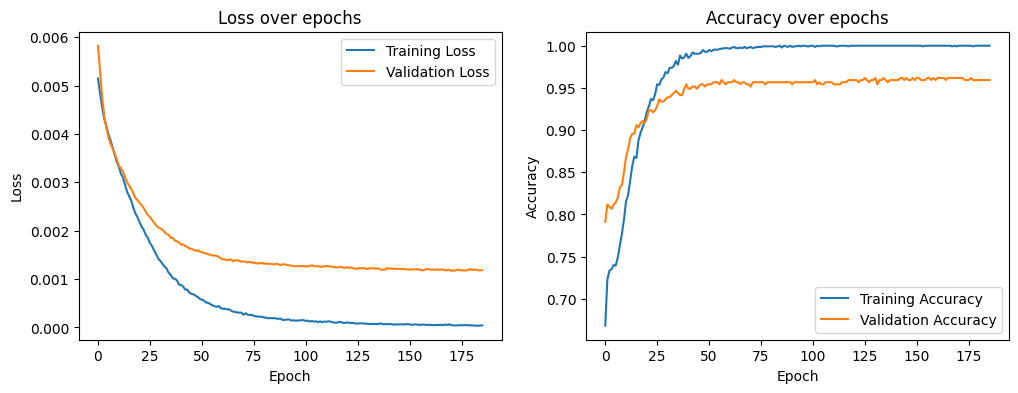

In [31]:
plot_training_history(training_history)

100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


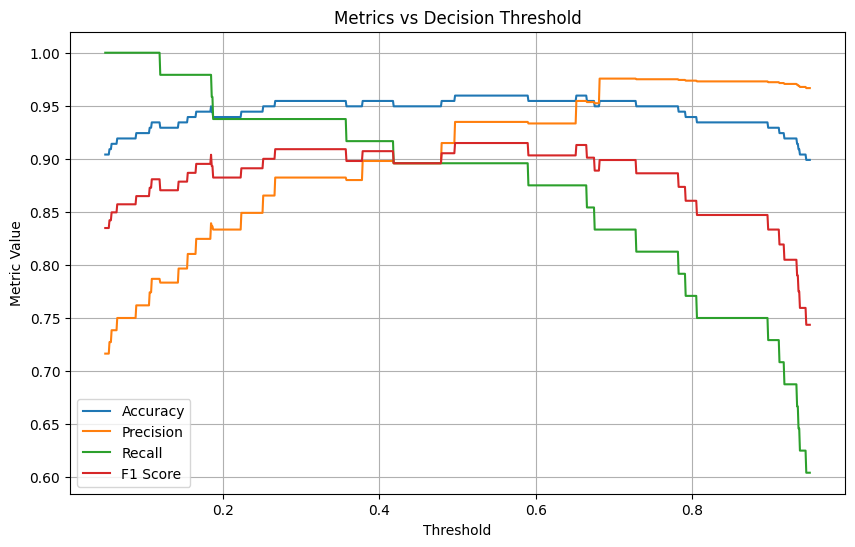

AUC-ROC: 0.99


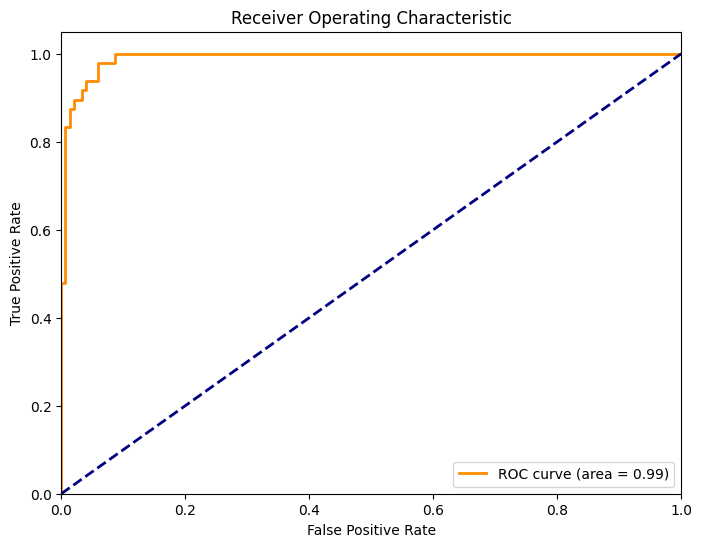

In [32]:
# cls_model_chkpoint_path = "cls_chkpoint_resnet50/checkpoint_2023-12-19-00-14_lr_0.0003_batch_128/checkpoint_epoch_25.pth"
# model = load_resnet50(cls_model_chkpoint_path, device)
# model.to(device)

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilities of class 1
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Range of thresholds to evaluate
thresholds = np.linspace(0.05, 0.95, 1000)

# Metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    # Make predictions based on the threshold
    predicted = (np.array(all_probs) >= threshold)

    # Calculate metrics
    accuracies.append(accuracy_score(all_labels, predicted))
    precisions.append(precision_score(all_labels, predicted, zero_division=0))
    recalls.append(recall_score(all_labels, predicted, zero_division=0))
    f1_scores.append(f1_score(all_labels, predicted, zero_division=0))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.title('Metrics vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f'AUC-ROC: {roc_auc:.2f}')

# Optional: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       150
           1       0.90      0.92      0.91        48

    accuracy                           0.95       198
   macro avg       0.94      0.94      0.94       198
weighted avg       0.95      0.95      0.95       198



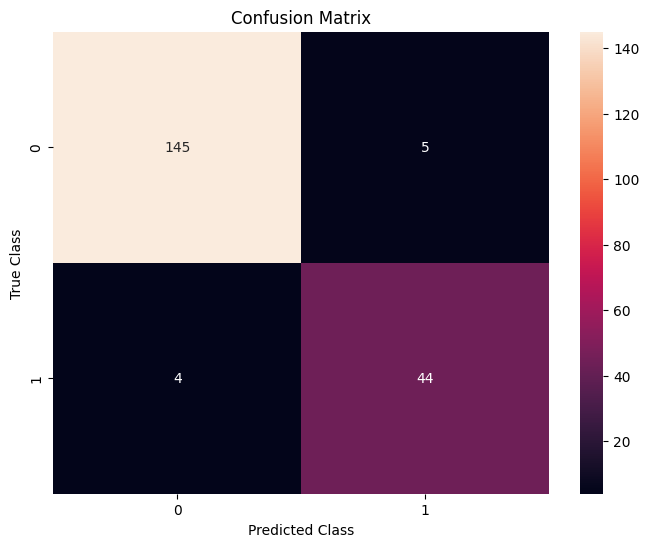

In [33]:
threshold = 0.4
predicted = (np.array(all_probs) >= threshold)
print(classification_report(all_labels, predicted))
confusion_matrix_df =confusion_matrix(all_labels, predicted, )
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [42]:


def show_feature_map(model, image_path):
    img = Image.open(image_path)

    feature_maps = []

    def hook_function(module, input, output):
        feature_maps.append(output)

    # Register the hook to the first convolutional layer of the first block of layer1
    hook = model.layer1[0].conv1.register_forward_hook(hook_function)

    # Load an image


    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
    ])
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model(img_tensor)

    # Unregister the hook
    hook.remove()

    # Visualize the feature maps
    fm = feature_maps[0].squeeze(0)  # Get the feature maps

    # Plotting
    fig, axes = plt.subplots(8, 8, figsize=(20, 20))  # Adjust subplot dimensions as needed
    for i, ax in enumerate(axes.flat):
        if i < 64:  # Adjust this based on how many feature maps you want to visualize
            ax.imshow(fm[i].detach().cpu().numpy(), cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    plt.show()





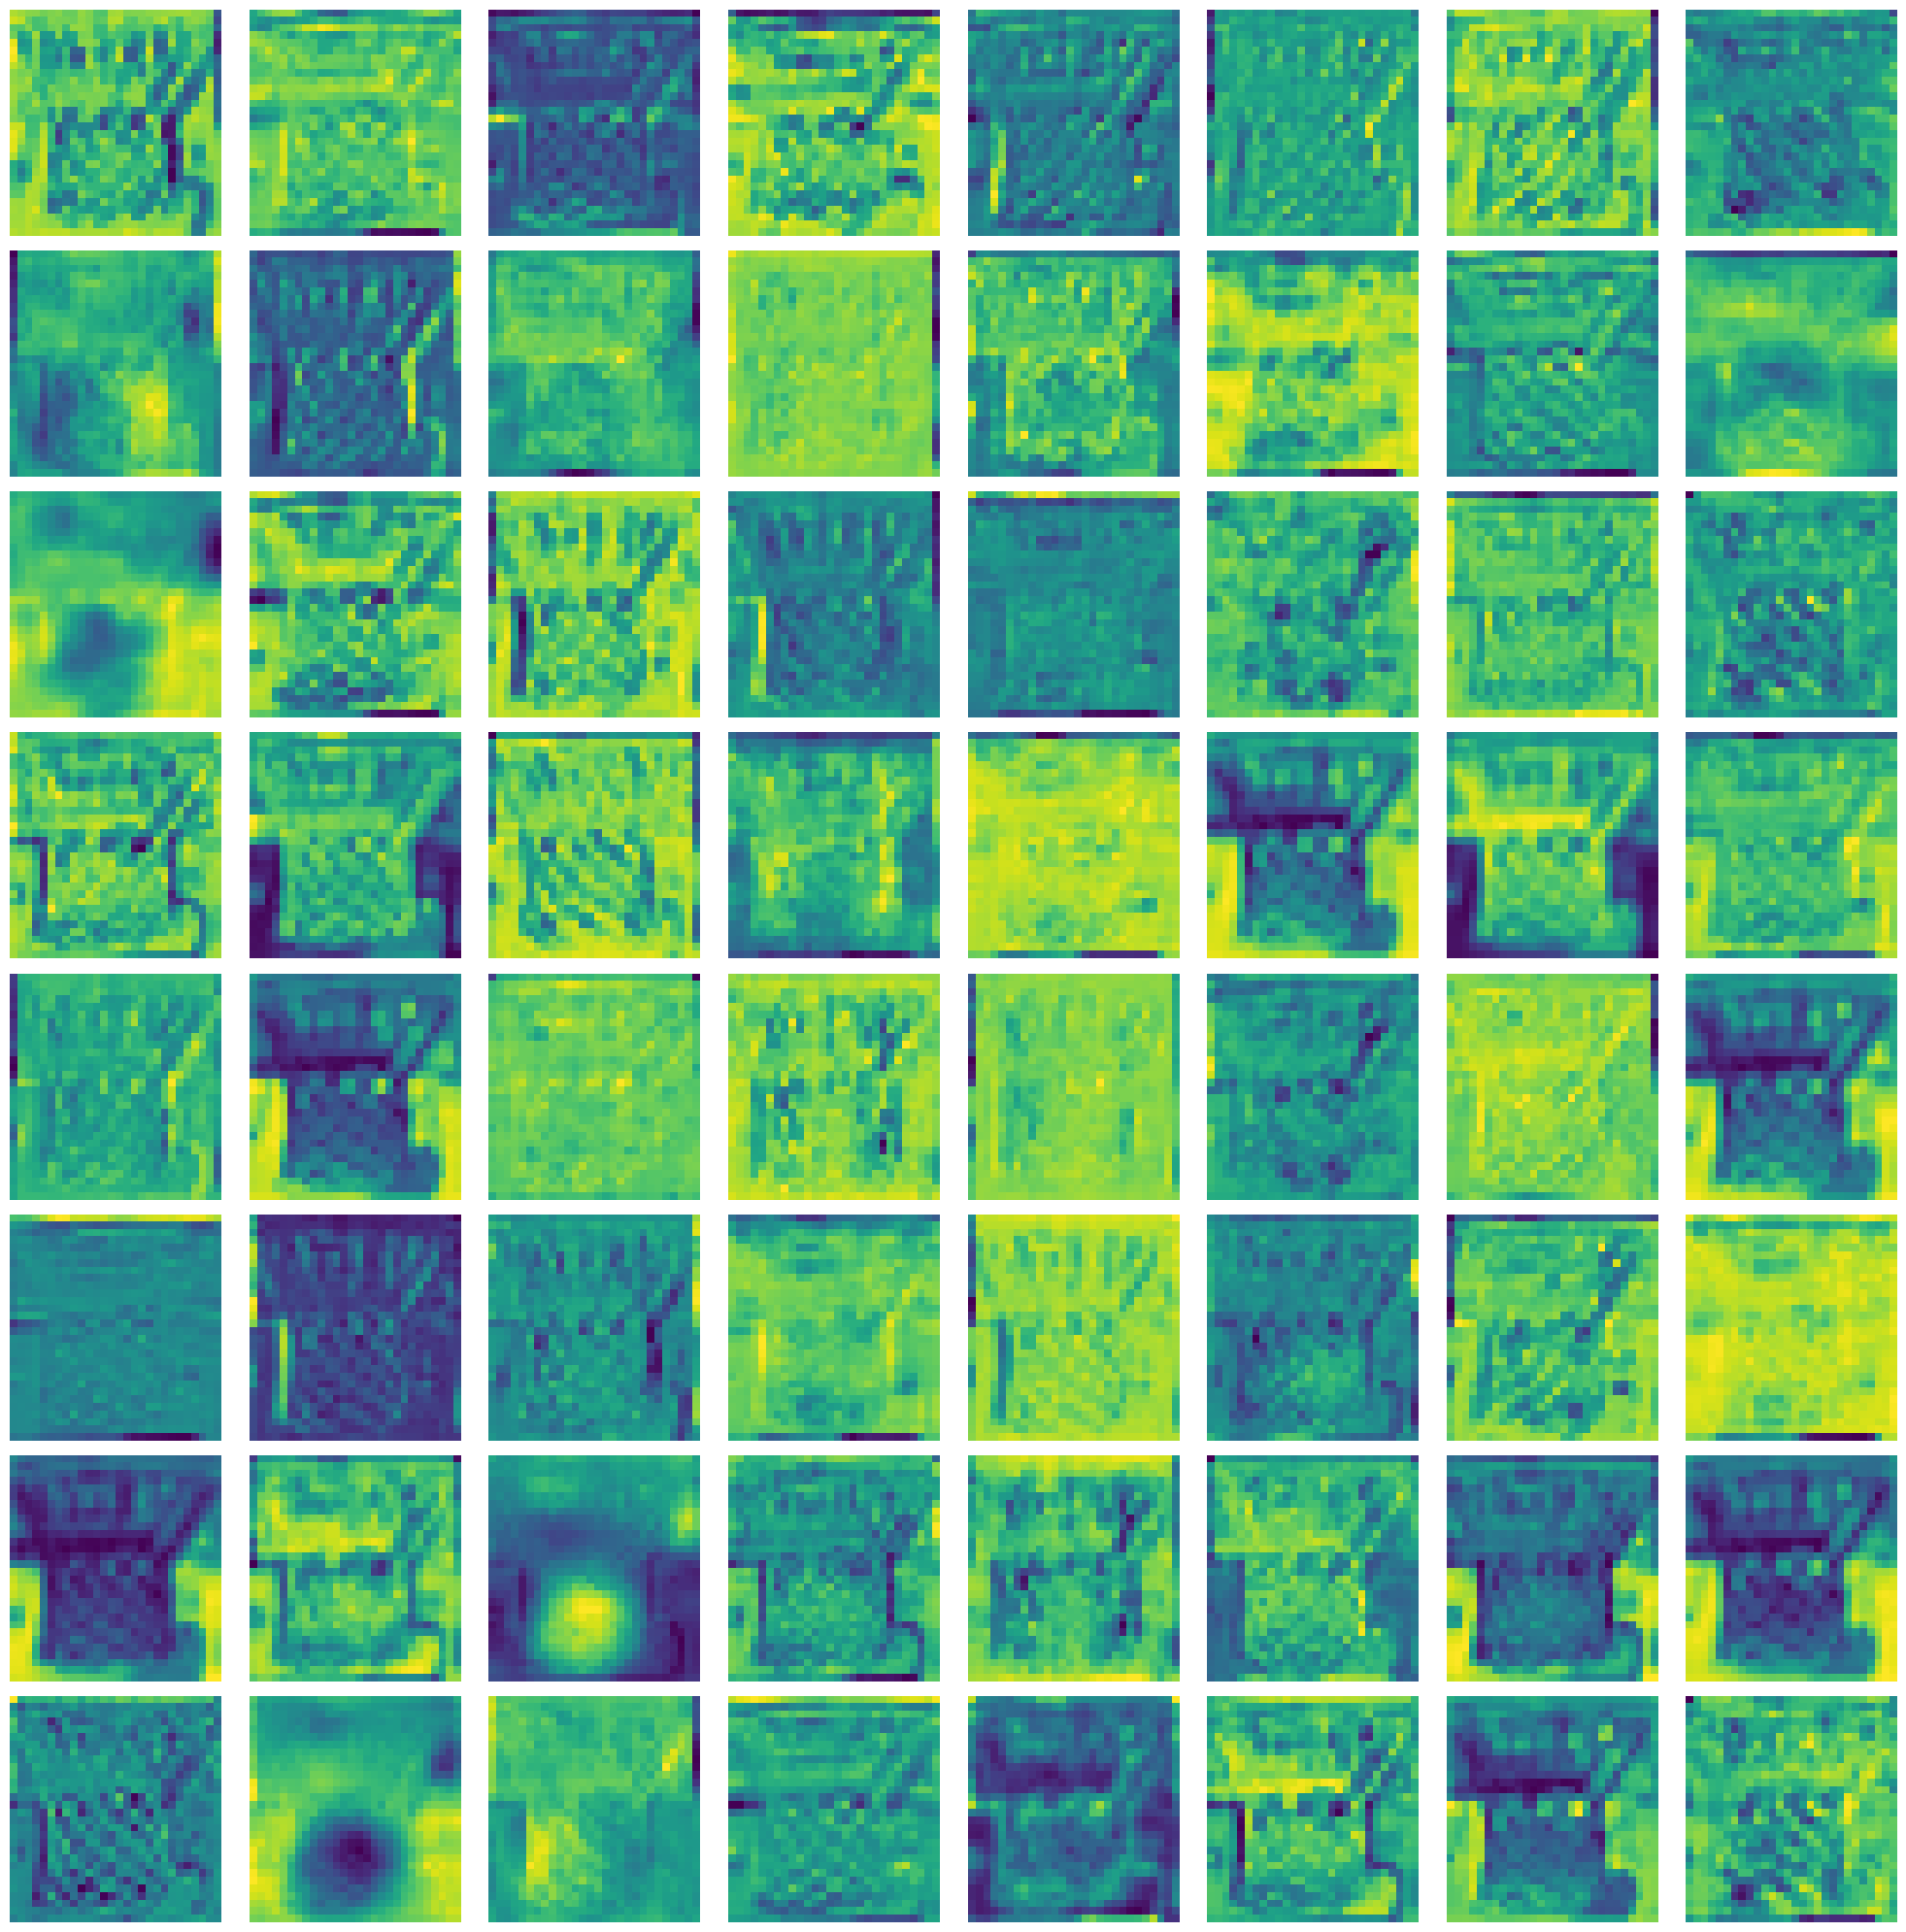

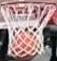

In [45]:
show_feature_map(model, 'classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg' )
Image.open('classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg')

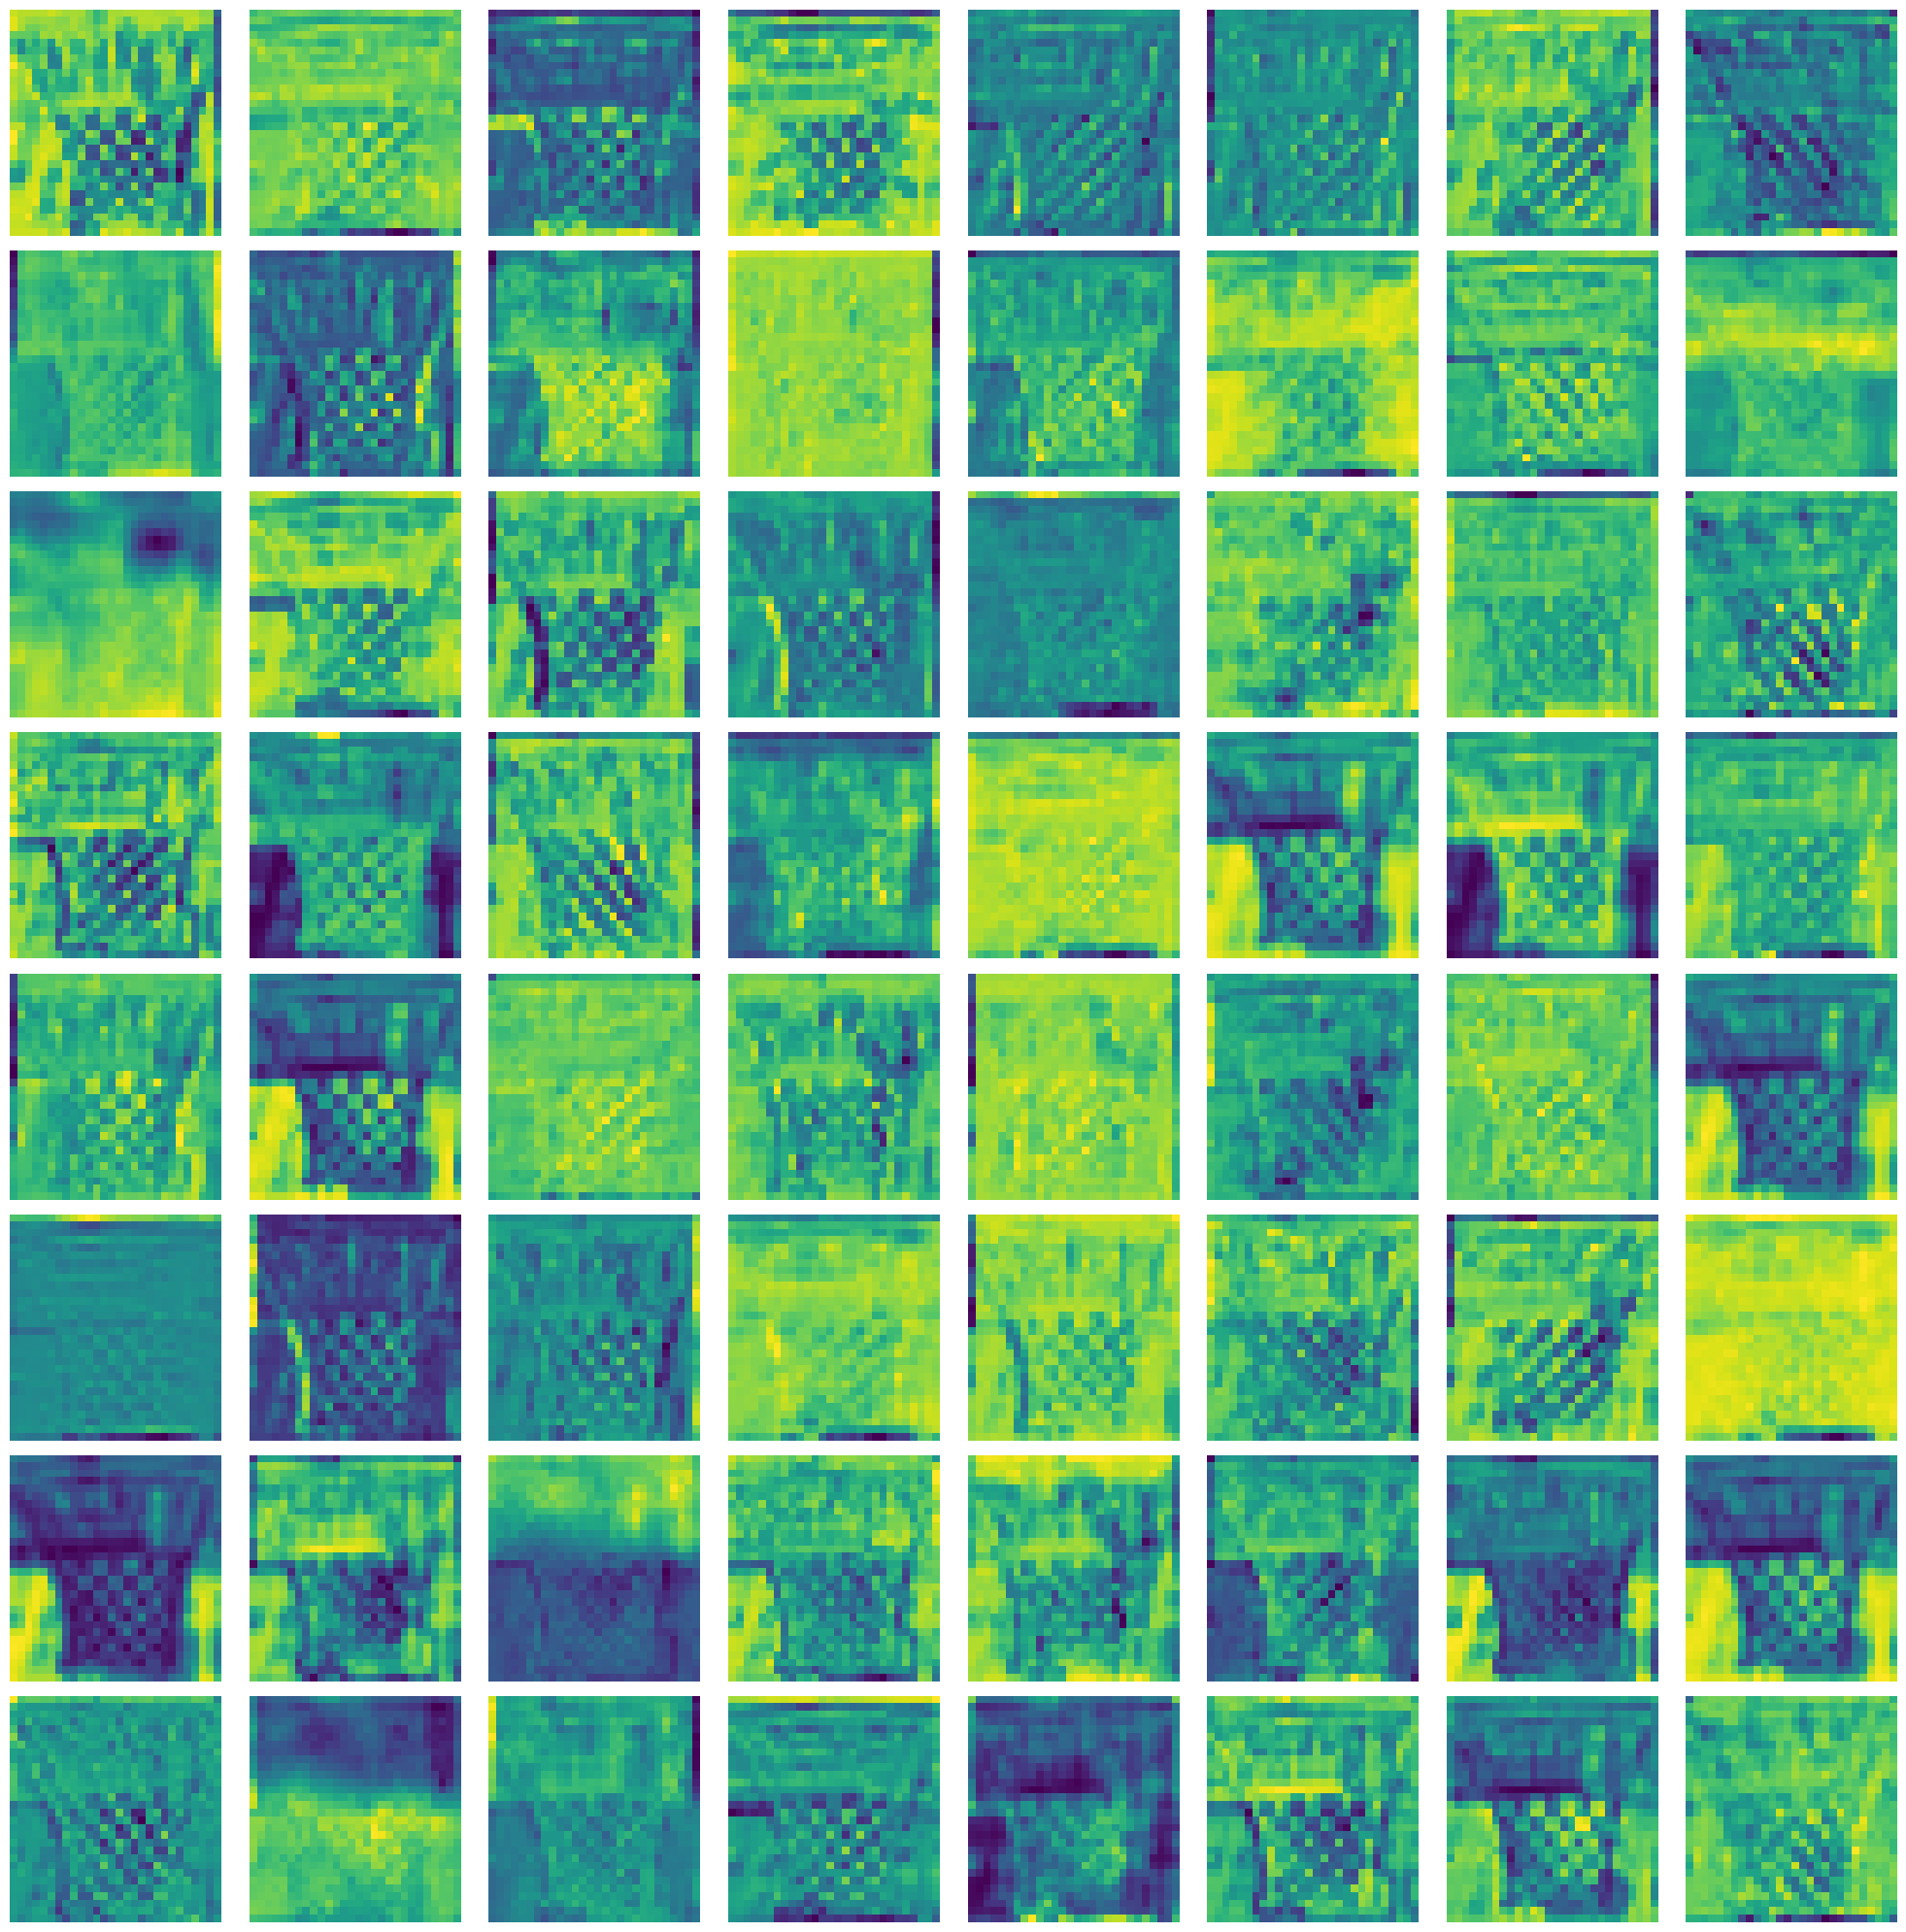

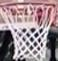

In [44]:
show_feature_map(model, "classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")
# display the image
Image.open("classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")